# Lesson 7

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
%matplotlib inline

We've learned he basics of linear regression, with one and multiple variables. 

Today we're going to focus on the question of whether one model or set of models is better than another.

We're going to start by going over classical methods, and then talk about methods using cross validation.

# Introduction

Why use classical metrics, like R^2, at all?

Why not just use cross-validation accuracy, since the goal is to make predictions on out-of-sample data?

To understand reason, recall bias-variance:

<img src=http://i.stack.imgur.com/JLDET.png>

**Discussion:** Is linear regression a "high bias" or "high variance" model?

Recall, in the context of regression, what overfitting means:

<img src="https://cloud.githubusercontent.com/assets/846010/11647961/77c2781e-9d3c-11e5-9793-363dab993e14.png">

## Classical metrics for understanding model fit

### R Squared

Formula = (explained variance) / (total variance)

<img src=http://www.rapidinsightinc.com/wordpress/wp-content/uploads/r-squared.png>

In [4]:
wd = '../../data/'
crickets = pd.read_csv(wd + 'crickets.csv')
# pd.read_csv('../../crickets_temp.csv')
crickets.head()

,crickets,temp
0,20.000000,88.599998
1,16.000000,71.599998
2,19.799999,93.300003
3,18.400000,84.300003
4,17.100000,80.599998


In [11]:
## biased fit
lm = linear_model.LinearRegression()
lm.fit(crickets[['crickets']], crickets['temp'])
lm.score(crickets[['crickets']], crickets['temp'])

0.69746514501673995

### Manual R-Squared Calc

In [20]:
mean_temp = crickets['temp'].mean()
y_diff = crickets['temp'] - mean_temp
y_diff_squared = y_diff**2
total_var = sum(y_diff_squared)

predictions = lm.predict(crickets[['crickets']])
pred_diff = crickets['temp'] - predictions
pred_diff_squared = pred_diff ** 2
unexplained_var = sum(pred_diff_squared)

print "R-squared: " + str(1 - unexplained_var / total_var)

predictions = lm.predict(crickets[['crickets']])
pred_diff = mean_temp - predictions
pred_diff_squared = pred_diff ** 2
explained_var = sum(pred_diff_squared)

print "R-squared: " + str(explained_var / total_var)

R-squared: 0.697465145017
R-squared: 0.697465145017


### Exercise: (20 minutes)

Another common metric (closely related to R squared) to see how good a regression is is the "mean squared error". Starting from this piece of documentation, calculate mean squared error for this model, both using SKLearn, and manually similar to the method above.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

# Cross validation

We covered last week how cross validation can prevent overfitting. 

Here's a great illustration of overfitting: http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

Here's a visual reminder of what cross validation is:

<img src='http://blog-test.goldenhelix.com/wp-content/uploads/2015/04/B-fig-1.jpg'>

In [86]:
from sklearn import cross_validation
wd = '../../'
basketball = pd.read_csv(wd + 'basketball.csv')

In [101]:
basketball.head()

,height,weight,pct_fg,pct_ft,ppg
0,6.8,225,0.442,0.672,9.2
1,6.3,180,0.435,0.797,11.7
2,6.4,190,0.456,0.761,15.8
3,6.2,180,0.416,0.651,8.6
4,6.9,205,0.449,0.900,23.2


### Splitting the data up into "X" and "Y"

In [97]:
basketball_x = basketball.loc[:,['height', 'weight', 'pct_fg', 'pct_ft']]
basketball_y = basketball.loc[:,['ppg']]

#### 5 fold cross validation on this dataset

In [98]:
kf = cross_validation.KFold(len(basketball), n_folds=5, shuffle=True)

In [99]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(basketball_x.iloc[train_index], basketball_y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(basketball_y.iloc[test_index], lm.predict(basketball_x.iloc[test_index])))
    scores.append(lm.score(basketball_x, basketball_y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 24.5232584242
R2: 0.208779911271
Model 2
MSE: 38.7558686392
R2: 0.209789739752
Model 3
MSE: 17.9042297378
R2: 0.217300520445
Model 4
MSE: 17.7095576305
R2: 0.215736068621
Model 5
MSE: 71.0103368288
R2: 0.1265166885
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 33.9806502521
Mean of R2 for all folds: 0.195624585718


In [100]:
lm = linear_model.LinearRegression().fit(basketball_x, basketball_y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(basketball_y, lm.predict(basketball_x))
print 'R2: ', lm.score(basketball_x, basketball_y)

~~~~ Single Model ~~~~
MSE of single model: 26.5654032851
R2:  0.2222506313


## Can we make this model better? (15 minutes)

**Exercise:** Try taking out features, and running the data through the same code as above, and seeing if you can identify any features that are not in fact adding to the likely accuracy of the model on _outside_ data.

# Regularization

You just "built" several different models - functions that take in data of a particular form and then output predictions about that data - by selecting different variables.

Now, we're going to talk about another way to "build different models" in the context of linear regression - regularization.

## Motivation

When you have many dependent variables, or predictors, trying to predict some outcome, a sign that these variables are overfitting is if the coefficients get extremely big. Regularization makes your model have a "penalty" for having large coefficients.

## Mathematics

Recall that when we form a linear model, we select the model that minimizes the squared error. For a model of the form
$$y_i = f(x_i) + e_i$$
we minimize the sum
$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2}$$
This is an example of a _loss function_, a function that measures the cost of inaccurate model predictions. To apply the technique of regularization, we modify the loss function with a term that penalizes more complex models. For example, we could use a loss function of the form:
$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha \theta_i ^2}$$

or 

The "alpha" term in there represents the "amount of regularization" we apply to our model. The higher alpha, the more we want to "penalize" our model for having large coefficients.

## "Lasso" and "Ridge" regression

Lasso regression applies what is called "L1" regularization to the model parameters, minimizing the cost function:

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha |\theta_i|}$$

By contrast, "Ridge" regression applies an "L2" regularization to the model parameters, minimizing the cost function:

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha \theta_i ^2}$$

## Boston dataset example

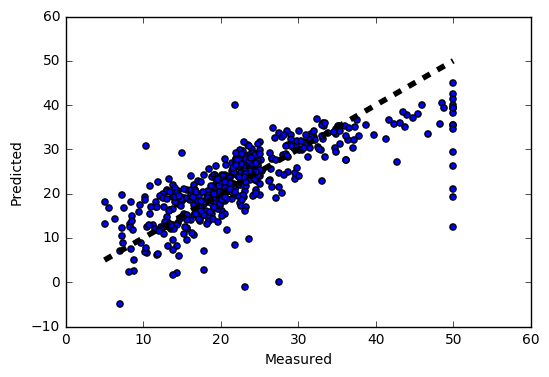

r^2: 0.740607742865


In [111]:
# Work through the cross-validation example, adding in r^2 calculations.
# Does cross-validation produce a better fit in this case? Why or why not?

import pandas as pd

# Without CV

from sklearn import datasets
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt

boston = datasets.load_boston()
X = boston.data
y = boston.target

lr = linear_model.LinearRegression()
lr.fit(boston.data, y)
predicted_nocv = lr.predict(boston.data)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print "r^2:", lr.score(X, y)

### R^2 with cross validation

In [128]:
# With CV

lm = linear_model.LinearRegression()

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True)
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm.fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 27.2538538619
R2: 0.738523814123
Model 2
MSE: 24.2390206117
R2: 0.737416430577
Model 3
MSE: 17.8125186221
R2: 0.739599132215
Model 4
MSE: 27.751615847
R2: 0.735334003474
Model 5
MSE: 22.5681704186
R2: 0.738431392717
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 23.9250358723
Mean of R2 for all folds: 0.737860954621


**Explanation:** Linear regression is slightly overfitting.

In [130]:
# With CV

lr = linear_model.Ridge()
predicted_cv = cross_val_predict(lr, X, y, cv=5)

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True)
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 13.482853453
R2: 0.739660534599
Model 2
MSE: 29.2771676006
R2: 0.739619440641
Model 3
MSE: 29.3798357547
R2: 0.735053817495
Model 4
MSE: 30.6718149138
R2: 0.737343022729
Model 5
MSE: 15.653857285
R2: 0.739057421448
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 23.6931058014
Mean of R2 for all folds: 0.738146847382


### Ridge regression example of tuning alpha parameter

In [131]:
# Note the "alpha = 0.5" method in 

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

lr = linear_model.Ridge()
predicted_cv = cross_val_predict(lr, X, y, cv=5)

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True)
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 26.7955394241
R2: 0.737273437192
Model 2
MSE: 20.534794448
R2: 0.738731387787
Model 3
MSE: 24.6809583127
R2: 0.736302631752
Model 4
MSE: 21.0268268153
R2: 0.739345478453
Model 5
MSE: 27.3538147957
R2: 0.736516380291
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 24.0783867592
Mean of R2 for all folds: 0.737633863095


### Exercise (20 minutes): Make a plot of the different cross validated scores of this model against different values of alpha to find the optimal alpha  

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

#### To get you started:

In [134]:
alphas = np.logspace(-10, 10, 21)
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(X, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(X))

Alpha: 1e-10
[[ -1.07170557e-01   4.63952195e-02   2.08602395e-02   2.68856140e+00
   -1.77957587e+01   3.80475246e+00   7.51061702e-04  -1.47575880e+00
    3.05655038e-01  -1.23293463e-02  -9.53463555e-01   9.39251272e-03
   -5.25466633e-01]]
21.8977792177
Alpha: 1e-09
[[ -1.07170557e-01   4.63952195e-02   2.08602395e-02   2.68856140e+00
   -1.77957586e+01   3.80475246e+00   7.51061693e-04  -1.47575880e+00
    3.05655038e-01  -1.23293463e-02  -9.53463555e-01   9.39251272e-03
   -5.25466633e-01]]
21.8977792177
Alpha: 1e-08
[[ -1.07170557e-01   4.63952195e-02   2.08602390e-02   2.68856140e+00
   -1.77957585e+01   3.80475246e+00   7.51061601e-04  -1.47575879e+00
    3.05655038e-01  -1.23293463e-02  -9.53463553e-01   9.39251273e-03
   -5.25466633e-01]]
21.8977792177
Alpha: 1e-07
[[ -1.07170556e-01   4.63952197e-02   2.08602347e-02   2.68856138e+00
   -1.77957575e+01   3.80475247e+00   7.51060676e-04  -1.47575878e+00
    3.05655036e-01  -1.23293464e-02  -9.53463542e-01   9.39251278e-03
   

### Or we can use grid search to make this faster

In [15]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(modeldata, y)


GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

##### Best score 

In [16]:
print gs.best_score_ 

-1814.09369133


##### mean squared error here comes in negative, so let's make it positive.

In [17]:
print -gs.best_score_ 

1814.09369133


##### explains which grid_search setup worked best

In [18]:
print gs.best_estimator_ 

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


##### shows all the grid pairings and their performances.

In [83]:
print gs.grid_scores_ 

[mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-10}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1.0000000000000001e-09}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-07}, mean: -1817.58711, std: 542.14317, params: {'alpha': 1.0000000000000001e-05}, mean: -1817.58707, std: 542.14331, params: {'alpha': 0.0001}, mean: -1817.58663, std: 542.14477, params: {'alpha': 0.001}, mean: -1817.58230, std: 542.15933, params: {'alpha': 0.01}, mean: -1817.54318, std: 542.30102, params: {'alpha': 0.10000000000000001}, mean: -1817.20111, std: 543.63587, params: {'alpha': 1.0}, mean: -1814.09369, std: 556.35563, params: {'alpha': 10.0}, mean: -1818.51694, std: 653.68607, params: {'alpha': 100.0}, mean: -2125.58777, std: 872.45270, params: {'alpha': 1000.0}, mean: -2458.08836, std: 951.30428, params: {'alpha': 10000.0}, me

## Mini-Project (rest of class / first 30-60 minutes of next class)

In [150]:
wd = '../../data/'
salary = pd.read_csv(wd + 'salary.csv')
salary.head()

,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350
2,male,full,10,doctorate,23,28200
3,female,full,7,doctorate,27,26775
4,male,full,19,masters,30,33696
